### 3.1 Simple Robbins Monro

Write the first order budget constraint as :$$F(w) = E[(R-\mu)(R-\mu)']w + \lambda \mathbf{1}_n = Sw + \lambda \mathbf{1}_n=0,$$ 
We can write $F(w) = E(f(w, R)),$ where $$f(w,R) = (R-\mu)(R-\mu)'w + \lambda\mathbf{1}_n$$
We can easily verify the 2 assumptions: 

* if $w*$ is the solution, $\forall w\in \mathbb{R}^n$,
\begin{eqnarray}
 \langle w - w*, F(w)\rangle &=& \langle w-w*, Sw + \lambda \mathbf{1}_n\rangle \\
 &=& \langle w-w*, S(w-w*) + Sw*+ \lambda \mathbf{1}_n\rangle \\
 &=&\langle w-w*, S(w-w*)\rangle >0
\end{eqnarray}


* $\forall w\in \mathbb{R}^n, E(f^2(w, R)) = E(w^TA^2w+2w^TA\cdot\lambda\mathbf{1}_n+n\lambda^2\leq C(1+|w|^2),$where$A = (R-\mu)(R-\mu)',$ when $C$ is quite large. 

In [1]:
import numpy as np
import scipy 
import scipy.linalg
import matplotlib.pyplot as plt
from scipy.integrate import quad
from tqdm import tqdm,trange

In [2]:
n = 3
mu = np.array([.05, .07, .06])  # R~ N(mu, S)
D = np.diag([.1, .14, .2])      # S = DKD
rho = 0.5
K = np.array([[1, rho, 0],
             [rho, 1, rho],
             [0, rho, 1]])
lambd = 0.3
S = np.matmul(np.matmul(D, K), D)

In [3]:
def f(w, R, lambd = lambd):
    """
    function for Robbins Monro regression
        E[f(w,R)] = F(w) = 0 
    
    inputs :
            w :   w_n-1 in the regression
            R :   A random vector to perform the RM
        lambd :   eigenvalue default by 0.3
    return : f(w,R)
    """
    t1 = R.reshape(n, 1)   # reshape R^n vectors into col-vectors
    t2 = mu.reshape(n, 1)
    return np.matmul((t1 - t2)*((t1 - t2).T), w) + lambd*np.ones((n, 1))

In [4]:
def plot_trace(h):
    l = np.shape(h)[0]
    hh = np.array(h)
    plt.plot(hh[:l,0])
    plt.ylim(-1.,1.)
    plt.show()
def theory_answer(S):
    inv = np.linalg.inv(S)
    w = np.matmul(inv, np.ones((n, 1)))/np.sum(inv)
    return w

100%|█████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:18<00:00, 52859.22it/s]


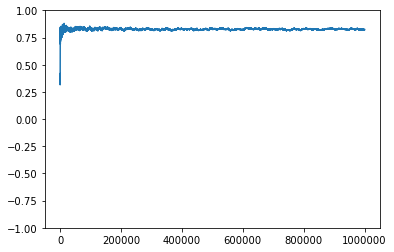

final result is 
 [[ 0.82358368]
 [-0.03598932]
 [ 0.21240563]]
compare with the theory result 
 [[ 0.82688391]
 [-0.0407332 ]
 [ 0.21384929]]


In [5]:
def Robbins_Monro_Regression(N = 10000, alpha = 0.6):
    R = np.random.multivariate_normal(mu, S, N)
    x = np.random.random(n)
    x = x/np.sum(x)
    w = [x.reshape(n,1)]     # initialization with equal value
    w_hist = [x.reshape(n,1)]
    rg = range(N)
    if N > 1e4 :
        rg = trange(N)
    for i in rg:
        w_tmp = w[-1] - 10.*f(w[-1], R[i])/np.power(i+1,alpha)
        w.append(w_tmp)
        w_hist.append(w_tmp/np.sum(w_tmp))
    plot_trace(w_hist)
    print("final result is \n {}".format(w[-1]/np.sum(w[-1])))
    print("compare with the theory result \n {}".format(theory_answer(S)))
    return w[-1]/np.sum(w[-1]),w,w_hist
x,_,_ = Robbins_Monro_Regression(N = 1000000,alpha = 0.6)

## 3.2

In [6]:
def S_rho(rho):
    D = np.diag([.1, .14, .2])
    # rho = 0.5
    K = np.array([[1, rho, 0],
                 [rho, 1, rho],
                 [0, rho, 1]])
    S = np.matmul(np.matmul(D, K), D)
    return S

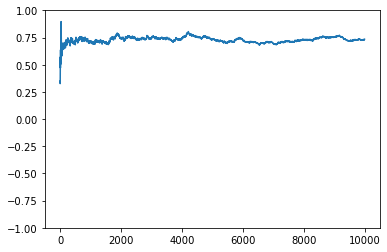

final result is 
 [[0.73428115]
 [0.09775626]
 [0.16796259]]
compare with the theory result 
 [[0.73492551]
 [0.09458501]
 [0.17048948]]


In [7]:
S = S_rho(rho=0.4)
_,_,_ = Robbins_Monro_Regression(alpha=0.6)

In [9]:
def UQSA_adapted(rho_min, rho_max, u0 = '', K = 1000, n = 3, a = 0.875, b = 0.3):   # mk
    m = [int(np.floor(np.power(k, b))) + 1 for k in range(K+1)]   #   mk[0] = 1
    if u0=='' : 
        u0 = np.random.randn(m[0] + 1, n)   

    B = [np.polynomial.legendre.Legendre.basis(deg=i,domain=np.array([rho_min, rho_max])) for i in range(np.max(m)+1)]   
        
    def W(m_k, rho, u0, Legendre_basis = B):
        return np.sum([u0[j]*Legendre_basis[j](rho) for j in range(m_k+1)], axis = 0)
#     trace = []
    for k in tqdm(range(1, K+1)):

        r = np.random.uniform(low = rho_min, high = rho_max)
        S = S_rho(r)
        R = np.random.multivariate_normal(mu, S)
        
        u = np.zeros((m[k] + 1, n))
        for i in range(m[k] + 1):
            w = W(m[k-1], r, u0)
#             trace.append(w[0])
            expect = (B[i](r) * f(w.reshape(n,1), R)).reshape(n)
            
            gamma = 1./np.power(k, a) #stepsize
            
            if i > m[k-1]:
                u[i] = - gamma * expect
            else:
                u[i] = u0[i] - gamma * expect
            
            u0 = u
    return u

In [10]:
def result_UQSA_adapted(r,K=1000):
    u = UQSA_adapted(0.3,0.5,K=K)
#     print(u)
    rg = range(int(np.floor(np.power(K, 0.3))) + 1 )
    B = [np.polynomial.legendre.Legendre.basis(deg=i,domain=np.array([0.6, 0.8])) for i in rg]
    result = np.zeros(3)
    
    for j in rg:
        result = result + B[j](r)*u[j]
#     plt.plot(trace)
    return result/np.sum(result)

In [11]:
result_UQSA_adapted(0.4, 1000)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 976.30it/s]


array([-0.13824188,  0.78895732,  0.34928456])

**Timestamp : 2020 Nov 12**

In [18]:
class UQSA_generator:
    def __init__(self,K,n = 3, r_min = 0.3, r_max = 0.5, gamma = None,m = None,M = None):
        self.K = K
        # steps of iteration
        if gamma is not None:
            self.gamma = gamma
        elif b is not None:
            self.gamma = [1./np.power(k,b) for k in range(K+1)]
        else:
            self.gamma = [1./np.power(k,0.1) for k in range(K+1)]
            
        self.m = [int(np.floor(np.power(k, 0.24))) + 1 for k in range(K+1)]
        if M is None:
            self.M = [10]*(K+1)
        else:
            self.M = M
        self.u0 = None
        self.u_record = None
        self.r_min = r_min
        self.r_max = r_max
        self.n = n
        self.mu = np.array([.05, .07, .06])  # TODO
        self.LB = [np.polynomial.legendre.Legendre.basis(deg=i,domain=np.array([r_min, r_max])) for i in range(np.max(self.m)+1)]
        
    def f(self, w, R, lambd = 0.3):
        """
        function for Robbins Monro regression
            E[f(w,R)] = F(w) = 0 

        inputs :
                w :   w_n-1 in the regression
                R :   A random vector to perform the RM
            lambd :   eigenvalue default by 0.3
        return : f(w,R)
        """
        t1 = R.reshape(n, 1)   # reshape R^n vectors into col-vectors
        t2 = mu.reshape(n, 1)
        return np.matmul((t1 - t2)*((t1 - t2).T), w) + lambd*np.ones((n, 1))

    def W(self,m_k, rho, u0):
#         print(u0[2])
#         print(self.LB[2](rho))
        return np.sum([u0[j]*self.LB[j](rho) for j in range(m_k+1)], axis = 0)
    
    def S_rho(self, rho):
        D = np.diag([.1, .14, .2])
        # rho = 0.5
        K = np.array([[1, rho, 0],
                     [rho, 1, rho],
                     [0, rho, 1]])
        S = np.matmul(np.matmul(D, K), D)
        return S
    
    def omega_theory(self,r):
        S = self.S_rho(r)
        inv = np.linalg.inv(S)
        w = np.matmul(inv, np.ones((n, 1)))/np.sum(inv)
        return w
    
    def u0_initialization(self):
        res = []
        for i in range(np.max(self.m)+1):
            res_i = []
            for j in range(3):
                func = lambda r: self.omega_theory(r)[j] * self.LB[i](r)
                res_i.append(quad(func,self.r_min,self.r_max)[0])
            res.append(res_i)
        self.u0 = res
        self.u_record = [res]
        return res

    
    def iteration(self):
        u0 = np.array(self.u0)
        n = self.n
        for k in trange(1, self.K+1):
            rho = []
            R = []
            u = np.zeros((self.m[k] + 1, n))
            
            for s in range(self.M[k]+1):
                r = np.random.uniform(low = self.r_min, high = self.r_max)
                rho.append(r)
                S = self.S_rho(r)
                R.append(np.random.multivariate_normal(self.mu, S))
                
            for i in range(self.m[k] + 1):
                expect = 0.0
                for s in range(1,self.M[k]+1): 
                    w = self.W(self.m[k-1], rho[s], u0)
                    expect += (self.LB[i](rho[s]) * self.f(w.reshape(n,1), R[s])).reshape(1,n)
                expect /= self.M[k]
                if i > self.m[k-1]:
                    u[i] = - self.gamma[k] * expect
                else:
                    u[i] = u0[i] - self.gamma[k] * expect
            u0 = u
            self.u_record.append(u)
        return u
#     def culculate_result(self,u,r):
#         x = self.W(np.max(self.m),r,u)
#         return
    def run_out(self, rs = None):
        if rs is None:
            rs = [0.5*(self.r_min + self.r_max)]
        self.u0_initialization()
        res = self.iteration()
        print("the u in the end of the iteration is : \n{}".format(res))
        
        for r in rs:
            x = self.W(np.max(self.m),r,res)
            print("-"*60)
            print("and the result of rho = {} is \n {}".format(r,x/np.sum(x)))
            print("compare with the theory result : \n {}\n".format(self.omega_theory(r).reshape(1,self.n)))
        res = []
        for i in range(50,self.K,5):
            res.append(uqsa.u_record[i][2][1])
        plt.plot(range(50,self.K,5),res)
        return res

C:\Users\konglulu\.conda\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.
100%|████████████████████████████████████████████████████████████████████████████| 50000/50000 [23:55<00:00, 34.83it/s]


the u in the end of the iteration is : 
[[-2.82884371e+01 -2.81714061e+00 -6.48815317e+00]
 [-2.03918860e+00  4.77560400e+00 -7.67917108e-01]
 [-5.70491453e-01  1.44504244e+00 -1.75593259e-01]
 [-6.24385188e-01 -1.09348229e-01 -9.75584001e-02]
 [-2.76512552e-01 -1.90266626e-01 -8.08442195e-01]
 [-1.02717238e+00 -2.30855728e-01 -3.45507613e-01]
 [-1.08460705e-01  3.59093196e-01  2.44145687e-01]
 [ 3.00118942e-01 -6.87693739e-03  5.42169584e-01]
 [-7.30373817e-02 -3.00267383e-01 -3.51638612e-01]
 [-4.48013838e-01 -9.27459754e-01  1.70919335e-01]
 [ 8.43315447e-02 -4.82393000e-01 -5.88373335e-01]
 [-6.98352323e-01 -1.55853875e-01  1.67391070e-01]
 [ 8.57198649e-02  1.17102300e-01  8.71397264e-04]
 [ 9.68471170e-01  5.26127858e-01 -5.02557298e-01]
 [-3.93850713e-01  3.68068869e-01  1.20859646e-01]]
------------------------------------------------------------
and the result of rho = 0.3 is 
 [0.67359564 0.13932665 0.18707771]
compare with the theory result : 
 [[0.67654597 0.17242183 0.1510

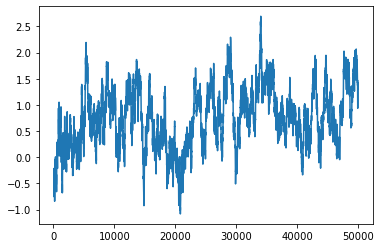

In [69]:

uqsa = UQSA_generator(K=50000)
u = uqsa.run_out([0.3,0.4,0.5,0.8])

C:\Users\konglulu\.conda\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.
100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 172.00it/s]

the u in the end of the iteration is : 
[[-2.73262756e+01 -2.26069968e+00 -4.55548298e+00]
 [-4.96038548e-01  2.34594273e+00 -9.24784247e-01]
 [-8.05881250e-02 -2.29006623e-01 -2.09164516e+00]
 [-8.89347870e-01  7.34201672e-03 -1.35886342e-01]
 [ 4.33838829e-01 -4.82913484e-01  2.41104253e-01]
 [-1.12283559e-01  1.99449228e-01  4.63602834e-01]
 [-7.92961504e-01 -7.82304725e-01 -6.40485997e-01]]
------------------------------------------------------------
and the result of rho = 0.3 is 
 [0.6731079  0.1616295  0.16526261]
compare with the theory result : 
 [[0.67654597 0.17242183 0.1510322 ]]

------------------------------------------------------------
and the result of rho = 0.4 is 
 [0.83522869 0.06472923 0.10004208]
compare with the theory result : 
 [[0.73492551 0.09458501 0.17048948]]

------------------------------------------------------------
and the result of rho = 0.5 is 
 [0.76788502 0.03154575 0.20056922]
compare with the theory result : 
 [[ 0.82688391 -0.0407332   0.21384

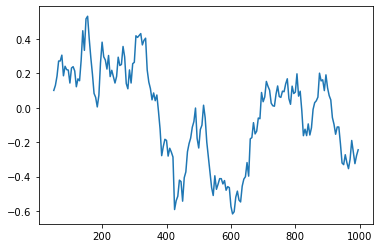

In [19]:
uqsa = UQSA_generator(K=1000)
u = uqsa.run_out([0.3,0.4,0.5,0.8])

In [10]:
np.power(10000,0.15)

3.9810717055349722

#### Time Stamp 24/11/2020

In [ ]:
class UQSA_generator:
    def __init__(self,K,n = 3, r_min = 0.3, r_max = 0.5, gamma = None,m = None,M = None):
        self.K = K
        # steps of iteration
        if gamma is not None:
            self.gamma = gamma
        elif b is not None:
            self.gamma = [1./np.power(k,b) for k in range(K+1)]
        else:
            self.gamma = [1./np.power(k,0.1) for k in range(K+1)]
            
        self.m = [int(np.floor(np.power(k, 0.24))) + 1 for k in range(K+1)]
        if M is None:
            self.M = [10]*(K+1)
        else:
            self.M = M
        self.u0 = None
        self.u_record = None
        self.r_min = r_min
        self.r_max = r_max
        self.n = n
        self.mu = np.array([.05, .07, .06])  # TODO
        self.LB = [np.polynomial.legendre.Legendre.basis(deg=i,domain=np.array([r_min, r_max])) for i in range(np.max(self.m)+1)]
        
    def f(self, w, R, lambd = 0.3):
        """
        function for Robbins Monro regression
            E[f(w,R)] = F(w) = 0 

        inputs :
                w :   w_n-1 in the regression
                R :   A random vector to perform the RM
            lambd :   eigenvalue default by 0.3
        return : f(w,R)
        """
        t1 = R.reshape(n, 1)   # reshape R^n vectors into col-vectors
        t2 = mu.reshape(n, 1)
        return np.matmul((t1 - t2)*((t1 - t2).T), w) + lambd*np.ones((n, 1))

    def W(self,m_k, rho, u0):
#         print(u0[2])
#         print(self.LB[2](rho))
        return np.sum([u0[j]*self.LB[j](rho) for j in range(m_k+1)], axis = 0)
    
    def S_rho(self, rho):
        D = np.diag([.1, .14, .2])
        # rho = 0.5
        K = np.array([[1, rho, 0],
                     [rho, 1, rho],
                     [0, rho, 1]])
        S = np.matmul(np.matmul(D, K), D)
        return S
    
    def omega_theory(self,r):
        S = self.S_rho(r)
        inv = np.linalg.inv(S)
        w = np.matmul(inv, np.ones((n, 1)))/np.sum(inv)
        return w
    
    def u0_initialization(self):
        res = []
        for i in range(np.max(self.m)+1):
            res_i = []
            for j in range(3):
                func = lambda r: self.omega_theory(r)[j] * self.LB[i](r)
                res_i.append(quad(func,self.r_min,self.r_max)[0])
            res.append(res_i)
        self.u0 = res
        self.u_record = [res]
        return res

    
    def iteration(self):
        u0 = np.array(self.u0)
        n = self.n
        for k in trange(1, self.K+1):
            rho = []
            R = []
            u = np.zeros((self.m[k] + 1, n))
            
            for s in range(self.M[k]+1):
                r = np.random.uniform(low = self.r_min, high = self.r_max)
                rho.append(r)
                S = self.S_rho(r)
                R.append(np.random.multivariate_normal(self.mu, S))
                
            for i in range(self.m[k] + 1):
                expect = 0.0
                for s in range(1,self.M[k]+1): 
                    w = self.W(self.m[k-1], rho[s], u0)
                    expect += (self.LB[i](rho[s]) * self.f(w.reshape(n,1), R[s])).reshape(1,n)
                expect /= self.M[k]
                if i > self.m[k-1]:
                    u[i] = - self.gamma[k] * expect
                else:
                    u[i] = u0[i] - self.gamma[k] * expect
            u0 = u
            self.u_record.append(u)
        return u
#     def culculate_result(self,u,r):
#         x = self.W(np.max(self.m),r,u)
#         return
    def run_out(self, rs = None):
        if rs is None:
            rs = [0.5*(self.r_min + self.r_max)]
        self.u0_initialization()
        res = self.iteration()
        print("the u in the end of the iteration is : \n{}".format(res))
        
        for r in rs:
            x = self.W(np.max(self.m),r,res)
            print("-"*60)
            print("and the result of rho = {} is \n {}".format(r,x/np.sum(x)))
            print("compare with the theory result : \n {}\n".format(self.omega_theory(r).reshape(1,self.n)))
        res = []
        for i in range(50,self.K,5):
            res.append(uqsa.u_record[i][2][1])
        plt.plot(range(50,self.K,5),res)
        return res